In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, \
  accuracy_score, \
  confusion_matrix

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2024-10-16 13:43:55--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip.1’

bank+marketing.zip.     [      <=>           ] 999.85K   712KB/s    in 1.4s    

2024-10-16 13:43:58 (712 KB/s) - ‘bank+marketing.zip.1’ saved [1023843]



In [3]:
!unzip bank+marketing.zip

Archive:  bank+marketing.zip
replace bank.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [12]:
!unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [2]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Encode the y value
df["y"] = (df["y"] == "yes").astype(int)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [7]:
df.dtypes.sort_values()

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
day           int64
y             int64
balance       int64
loan         object
poutcome     object
month        object
default      object
education    object
marital      object
job          object
housing      object
contact      object
dtype: object

In [5]:
numerical = [
    "age",
    "previous",
    "pdays",
    "campaign",
    "duration",
    "day",
    "balance"
]

categorical = [
    "loan",
    "poutcome",
    "month",
    "default",
    "education",
    "marital",
    "job",
    "housing",
    "contact"
]

In [6]:
from IPython.display import display
for col in categorical:
    display(df[col].value_counts())

loan
no     37967
yes     7244
Name: count, dtype: int64

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

default
no     44396
yes      815
Name: count, dtype: int64

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

housing
yes    25130
no     20081
Name: count, dtype: int64

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [7]:
# Split the dataset into train/val/test (60%/20%/20%)
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

print(len(df_train), len(df_val), len(df_test))

27126 9042 9043


In [8]:
# Question 1
auc_scores = []

for col in numerical:
    if roc_auc_score(df_train["y"], df_train[col]) < 0.5:
        auc_temp = roc_auc_score(df_train["y"], -df_train[col])
    else:
        auc_temp = roc_auc_score(df_train["y"], df_train[col])
    auc_scores.append((col, auc_temp))

In [9]:
auc_scores.sort(key=lambda x: x[1], reverse=True)
auc_scores

[('duration', 0.8147002759670778),
 ('previous', 0.5985653242764153),
 ('pdays', 0.5901276247352144),
 ('balance', 0.5888313805382317),
 ('campaign', 0.5714543015682159),
 ('day', 0.525957882383908),
 ('age', 0.512185717527344)]

Duration has the highest AUC

In [10]:
# Question 2
y_train = df_train["y"]
y_val = df_val["y"]
y_test = df_test["y"]

del df_train["y"]
del df_val["y"]
del df_test["y"]

In [11]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [12]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.fit_transform(test_dicts)

In [13]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred_threshold = (y_pred > 0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
round(roc_auc_score(y_val, y_pred), 3)

0.901

In [20]:
confusion_matrix(y_val, y_pred_threshold)

array([[7753,  191],
       [ 733,  365]])

In [22]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_threshold).ravel()

7753

I cant get the exact numbers hm, so I think the closest would be 0.89

In [17]:
# Question 3
threshold = np.linspace(0, 1, 101)


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [39]:
precision_list = []
recall_list = []
for t in threshold:
    y_pred_t = (y_pred > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precision_list.append(p)
    recall_list.append(r)

precision_list = np.array(precision_list)
recall_list = np.array(recall_list)

/var/folders/7q/mffjrdnx44ndxstdb3knl71r0000gr/T/ipykernel_97686/2356876158.py:6: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [31]:
%matplotlib inline

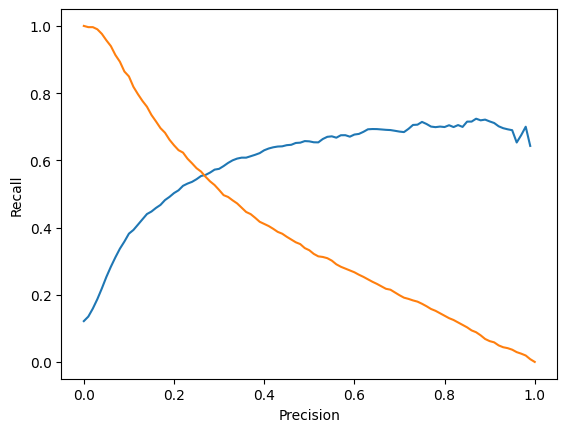

In [41]:
plt.figure()
plt.plot(threshold, precision_list)
plt.plot(threshold, recall_list)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

The precision and recall intersect between 0.2 - 0,4. The exact match is in 0.265

In [42]:
# Question 4
# F1 Score
f1_scores = []
for t in threshold:
    y_pred_t = (y_pred > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()
    r = tp / (tp + fn)
    p = tp / (tp + fp)
    f1_score = 2 * ((p * r) / (p + r))
    f1_scores.append(f1_score)

/var/folders/7q/mffjrdnx44ndxstdb3knl71r0000gr/T/ipykernel_97686/4003107099.py:8: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


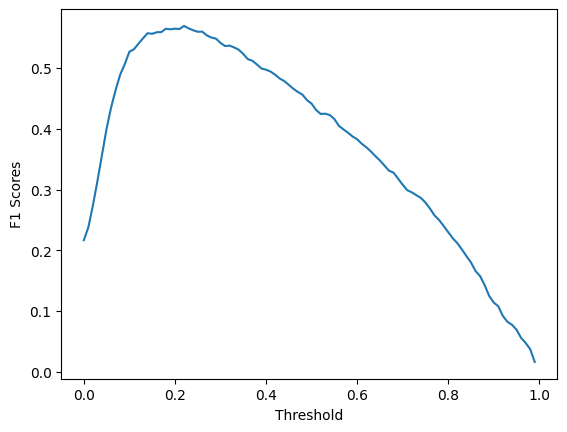

In [43]:
plt.plot(threshold, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Scores")
plt.show()

In [47]:
# Max F1 Score
idx = f1_scores.index(max(f1_scores))
print(f"Threshold with max F1 Scores: {threshold[idx]}")

Threshold with max F1 Scores: 0.22


In [70]:
df_ft = df_full_train.copy()
y_ft = df_ft["y"]
y_ft = y_ft.to_numpy()
del df_ft["y"]

X_dicts = df_ft.to_dict(orient='records')
X_ft = dv.transform(X_dicts)
X_ft

array([[5.200e+01, 0.000e+00, 2.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [5.000e+01, 3.300e+02, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.500e+01, 3.000e+02, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        3.000e+00],
       ...,
       [4.800e+01, 4.191e+03, 6.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.500e+01, 1.783e+03, 1.100e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.500e+01, 3.490e+02, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+00]])

In [75]:
Kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
kfold_generator = Kf.split(X_ft, y_ft)

In [76]:
auc_score_list = []
for i, (train_idx, test_idx) in enumerate(kfold_generator):
    X_train = X_ft[train_idx]
    y_train = y_ft[train_idx]
    X_test = X_ft[test_idx]
    y_test = y_ft[test_idx]

    mdl = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    mdl.fit(X_train, y_train)

    y_prd = mdl.predict_proba(X_test)[:, 1]
    y_prd_t = (y_prd > 0.5).astype(int)

    auc_score_list.append(roc_auc_score(y_test, y_prd_t))

In [79]:
auc_score_list = np.array(auc_score_list)
print(f"The standard deviation between K-Fold is: {round(np.std(auc_score_list), 3)}")

The standard deviation between K-Fold is: 0.006


In [80]:
# Question 6
Kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
kfold_generator = Kf.split(X_ft, y_ft)

In [81]:
auc_score_list_C = []
for i, (train_idx, test_idx) in enumerate(kfold_generator):
    for C in [0.000001, 0.001, 1]:
        X_train = X_ft[train_idx]
        y_train = y_ft[train_idx]
        X_test = X_ft[test_idx]
        y_test = y_ft[test_idx]

        mdl = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        mdl.fit(X_train, y_train)

        y_prd = mdl.predict_proba(X_test)[:, 1]
        y_prd_t = (y_prd > 0.5).astype(int)

        auc_score_list_C.append((C, roc_auc_score(y_test, y_prd_t)))

In [83]:
auc_score_list_C.sort(key=lambda x:x[1], reverse=True)

In [84]:
auc_score_list_C

[(1, 0.6714782974066921),
 (1, 0.6652556662874366),
 (1, 0.65785390507838),
 (1, 0.6564358873948329),
 (1, 0.6542964367284905),
 (0.001, 0.5911989930867287),
 (0.001, 0.5869371574001566),
 (0.001, 0.5812749589046087),
 (0.001, 0.5806501667887409),
 (0.001, 0.5784361246328433),
 (1e-06, 0.5439176984678122),
 (1e-06, 0.5388331711979889),
 (1e-06, 0.5374169092508456),
 (1e-06, 0.5319267173927232),
 (1e-06, 0.5300840935472485)]

The highest score is obtained with C = 1

In [90]:
auc_score_list_C = np.array(auc_score_list_C)
print(f"Mean: {np.mean(auc_score_list_C[:, 1])}")
print(f"STD: {np.std(auc_score_list_C[:, 1])}")


Mean: 0.5937330789043685
STD: 0.05165405132289081
